In [3]:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


In [18]:
df=pd.read_csv(r"netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [19]:
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

In [20]:
missing_values=df.isnull().sum()
missing_values

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [21]:
objec=["type","title","country","release_year","rating"]
df_object=df[objec]
#df_object["rating"].unique()
#we will extract missing ratings for future expect using machine learning so drop it for now to train data set
#rating_unknown=df_object[(df_object["rating"].isna()) |(df_object["rating"]=="NR") |(df_object["rating"]=="UR")].reset_index()
#rating_unknown=rating_unknown.drop(columns=["index"])
#print(rating_null.head())
#print(future.head())
df_object=df_object[df_object["rating"].notnull()]
#good now we removed all missing data from rating now let's deal with missing data in country
#It seems like data isn't grouped by country so we can't backfill or frontfill to fill up missing countries
#since we have 7780 records, let's remove all rows for country inputs are null
df_object.shape
df_object=df_object[df_object["country"].notnull()]
#changing some columns name for views to understand easily
#type has only 2 unique values TV or movie 
df_object=df_object.rename(columns={"type":"TV/Movie","release_year":"year","rating":"Recommended age"})
#print(df_object["Recommended age"].unique())
#it seems like Recommneded age can't be easily understandable so let's modify them and 
#when we look at the unique values,we sees UR,NR which menas "not rated" or "unrated"
def rating(x):
    if x=="TV-MA":
        return "19+"
    elif x=="R":
        return "17+"
    elif x=="PG-13":
        return "13+"
    elif x=="TV-14":
        return "14+"
    elif x=="TV-PG":
        return "10+"
    elif x=="TV-G":
        return "0+"
    elif x=="TV-Y":
        return "0+"
    elif x=="TV-Y7":
        return "7+"
    elif x=="PG":
        return "8+"
    elif x=="G":
        return "0+"
    elif x=="NC-17":
        return "17+"
    elif x=="TV-Y7-FV":
        return "7+"
    else:
        return "not rated"
#apply rating function to recommended age column
df_object["Recommended age"]=df_object["Recommended age"].apply(lambda x: rating(x))
#print(df_object["Recommended age"])
#let's count how many UN and RN there so we can decide if we need to remove it or merge for future prediction
lst=["19+","17+","13+","0+","14+","8+","7+","not rated","10+"]
#for items in lst:
#    print (df_object[df_object["Recommended age"] == items].count().unique())
count_rating_present=pd.DataFrame([2704,666,383,426,1795,244,226,89,741],index=lst)
count_rating_present=count_rating_present.rename(columns={0:"count"})
count_rating_present
total_number=np.product(df_object.shape)
#print(total_number)
missing=df_object.isnull().sum()
total_missing=missing.sum()
#print(total_missing)
percent=(total_missing/total_number)*100
#print(percent)
#we see that we have 89 cases for unrated/not rated ratings and they are only 0.2% of all cells so let's just drop them 
df_object=df_object[df_object["Recommended age"] != "not rated"]
df_object=df_object[df_object["country"]=="United States"]
#great that we have no missing values anymore
df_object.isnull().sum()

TV/Movie           0
title              0
country            0
year               0
Recommended age    0
dtype: int64

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
#df_object["Recomended age int"]=df_object["Recommended age"].str.replace(r"+","").astype("int64")
age_dummies=pd.get_dummies(df_object["Recommended age"])
df_object=pd.concat([df_object,age_dummies],axis=1)
df_object=df_object.sort_values(by='year')
df_object=df_object.groupby("year").sum()
df_object=df_object[["0+","7+","8+","10+","13+","14+","17+","19+"]]
df_object.head()

,0+,7+,8+,10+,13+,14+,17+,19+
year,,,,,,,,
1942,0,0,0,0,0,2,0,0
1943,0,0,0,3,0,0,0,0
1944,0,0,0,1,0,1,0,0
1945,0,0,0,0,0,2,0,1
1946,0,0,0,1,0,1,0,0


In [24]:
def year_validation():
    df=df_object
    while True:
        try:
            user_input=int(input("Which year you want to look into? "))
            if user_input not in df.index:
                raise ValueError
            break
        except ValueError:
            print("Wrong input. Please select from 1942-2020")
    return user_input
year_validation()
    
        

Wrong input. Please select from 1942-2020


2000

Here is the result to compare


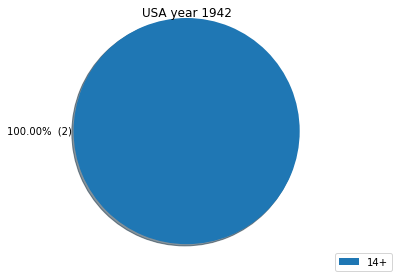

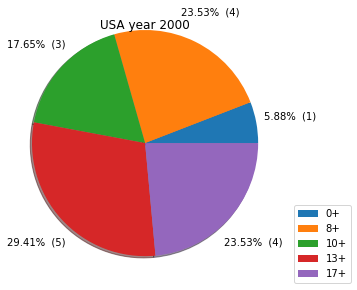

In [25]:

def piechart():
    df=df_object
    labels=[]
    recommended_age=[]
    while True:
        user_action=input("type Y for compare year and N for show result ")
        if user_action[0].lower()=="y":
            year=year_validation()
            labels=list(df_object.columns[df_object.loc[year]!=0])
            recommended_age=list(df_object.loc[year][df_object.loc[year]!=0])
            fig1,ax1 = plt.subplots()
            ax1.pie(recommended_age,shadow=True,autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(recommended_age)/100),pctdistance=1.3,radius=1.3)
            ax1.legend(labels, bbox_to_anchor=(1,0), loc="lower right", 
                          bbox_transform=plt.gcf().transFigure)
            ax1.set_title("USA year {}".format(year))
            continue
        elif user_action[0].lower()=="n":
            print("Here is the result to compare")
            break
        else:
            print("wrong input press y or n")
            continue
        break
    plt.show()
piechart()